In [160]:
import matplotlib.pyplot as plt

import  seaborn as sns
sns.set_style("darkgrid")

from ExperientalTools import *

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
%reload_ext autoreload
%autoreload 2

## get the dataset

In [161]:
(tr_x,tr_y) = prepare_dataset(train_path="datasets/ML-CUP21-TR.csv",unique=True)

In [162]:
# dictionary to save the results
results={}

## Constants

In [163]:
SIZE_RESERVOIR = 200
LAMBDA_REG = 1
MAX_ITER = 30000
PRECISION = 1e-2

## fix the resevoir

In [164]:
resevoir = np.random.uniform(-1, 1, (SIZE_RESERVOIR, 10))
H = sigmoid(resevoir @ tr_x)
E = H @ H.T + np.power(LAMBDA_REG, 2) * np.eye(H.shape[0])

In [165]:
condition_number = np.linalg.cond(E)
print(f"Condition number of E: {condition_number}")

Condition number of E: 74100.74061997635


# OPTIMAL SOLUTION

In [166]:
# Calculate the optimal solution
start_optimal = datetime.datetime.now()
w_star, _, _, _ = np.linalg.lstsq(E, H @ tr_y.T, rcond=-1)
end_optimal = (datetime.datetime.now() - start_optimal).microseconds

In [167]:
results["Optimal"] = mse(w_star.T@H, tr_y), "-", end_optimal

In [168]:
print("Mean square error: ", results["Optimal"][0])
print("Time: ", results["Optimal"][2])

Mean square error:  1.57514089968375


## Cholesky solution

In [169]:
output = fit_cholesky(tr_x, tr_y, lambda_=LAMBDA_REG, resevoir=resevoir, verbose=True)
cholesky = output["model"]
time = output["elapsed_time"]

In [170]:
cholesky_rel_gap_sol = np.linalg.norm(cholesky.w2 - w_star.T, ord="fro")/np.linalg.norm(w_star, ord="fro")
results["Cholesky"] = (get_results(cholesky, tr_x, tr_y), cholesky_rel_gap_sol, time)

In [171]:
print("Cholesky Mean square error: ", results["Cholesky"][0])
print("Cholesky Relative Gap Sol: ", results["Cholesky"][1])

Cholesky Mean square error:  1.5751408996835052
Cholesky Relative Gap Sol:  2.1370464888682082e-11


## Iterative methods

In [172]:
output_sgd = fit_sgd(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, max_inters=MAX_ITER,
                        eps=PRECISION, resevoir=resevoir, w_star=w_star.T, verbose=True)
classical_sgd = output_sgd["model"]
time = output_sgd["elapsed_time"]

In [173]:
sgd_gap_sol = output_sgd["results"]["Rel_Gap_Sol"].tail(1).values[0]
results["classical-SGD"] = get_results(classical_sgd, tr_x, tr_y), sgd_gap_sol, time

In [174]:
print("Mean square error: ", results["classical-SGD"][0])
print("Relative Gap Sol: ", results["classical-SGD"][1])

Mean square error:  1.6957334845737588
Relative Gap Sol:  0.4808742133267302


In [175]:
output_fista = fit_fista(x_train=tr_x, y_train=tr_y, lambda_=LAMBDA_REG, max_inters=MAX_ITER,
                  eps=PRECISION, resevoir=resevoir, w_star=w_star.T, verbose=True)
fista = output_fista["model"]
time = output_fista["elapsed_time"]

In [176]:
fista_gap_sol = output_fista["results"]["Rel_Gap_Sol"].tail(1).values[0]
results["Fista"] = get_results(fista, tr_x, tr_y), fista_gap_sol, time

In [177]:
print("Mean square error: ", results["Fista"][0])
print("Relative Gap Sol: ", results["Fista"][1])

Mean square error:  1.5751482231025535
Relative Gap Sol:  0.0005018062956717223


In [178]:
output_fista["results"]

,MSE,Rel_Gap_Sol
iters,,
0,37.330396,1.123332
1,37.330396,1.123332
2,25.141616,1.120716
3,15.867552,1.118550
4,9.950151,1.116944
...,...,...
29995,1.575148,0.000502
29996,1.575148,0.000502
29997,1.575148,0.000502


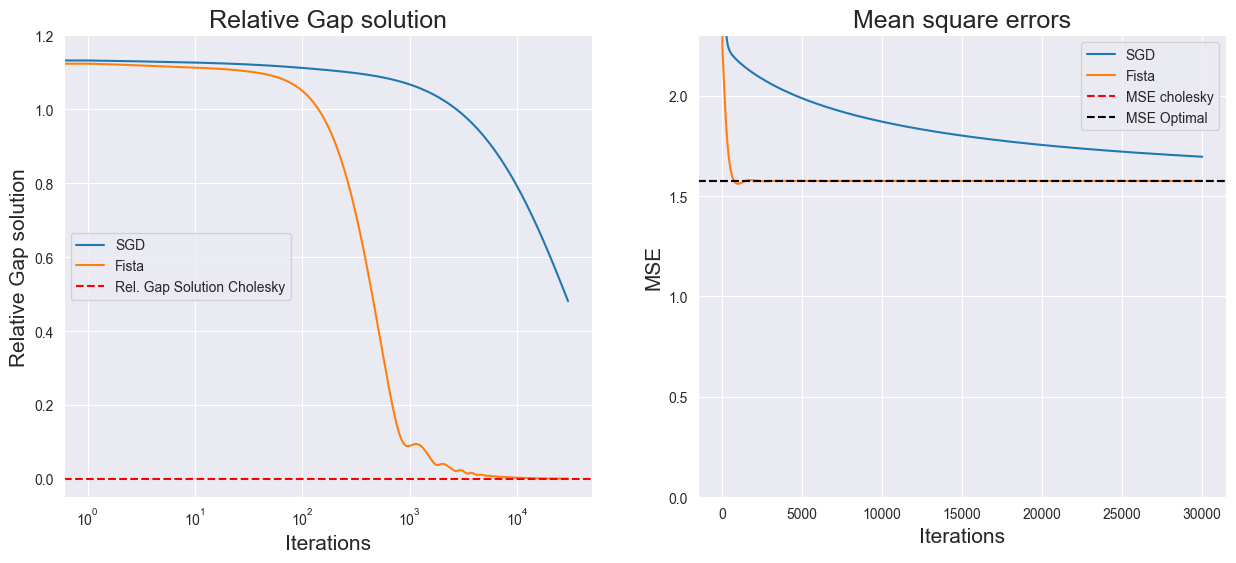

In [179]:
_, axs = plt.subplots(ncols=2,figsize=(15,6))

sns.lineplot(data=output_sgd["results"], x=output_sgd["results"].index, y="Rel_Gap_Sol", ax=axs[0], label="SGD")
sns.lineplot(data=output_fista["results"], x=output_fista["results"].index, y="Rel_Gap_Sol", ax=axs[0], label="Fista")
axs[0].axhline(y=cholesky_rel_gap_sol, label="Rel. Gap Solution Cholesky", color="red", linestyle="--")
axs[0].set_title("Relative Gap solution",fontsize=18)
axs[0].set_ylabel("Relative Gap solution",fontsize=15)
axs[0].set_xlabel("Iterations",fontsize=15)
axs[0].set_ylim([-0.05,1.2])
axs[0].set_xscale("log")
axs[0].legend()


sns.lineplot(data=output_sgd["results"], x=output_sgd["results"].index, y="MSE", ax=axs[1], label="SGD")
sns.lineplot(data=output_fista["results"], x=output_fista["results"].index, y="MSE", ax=axs[1], label="Fista")
axs[1].axhline(y=results["Cholesky"][0], label="MSE cholesky", color="red", linestyle="--")
axs[1].axhline(y=results["Optimal"][0], label="MSE Optimal", color="black", linestyle="--")
axs[1].set_title("Mean square errors",fontsize=18)
axs[1].set_ylabel("MSE",fontsize=15)
axs[1].set_xlabel("Iterations",fontsize=15)
axs[1].set_ylim([0, 2.3])
axs[1].legend()

plt.show()


In [180]:
print(f"{'Method' : ^20}{'MSE' : ^30}{'Rel. gap sol' : ^30}{'Time(microseconds)' : ^30}")

for k,v in results.items():
    print(f"{k : ^20}{v[0]:^30}{v[1] : ^30}{v[2] : ^30}")

       Method                    MSE                       Rel. gap sol               Time(microseconds)      
      Optimal              1.57514089968375                     -                           46424             
      Cholesky            1.5751408996835052          2.1370464888682082e-11                142525            
   classical-SGD          1.6957334845737588            0.4808742133267302                  921311            
       Fista              1.5751482231025535          0.0005018062956717223                 771185            
